In [1]:
import numpy as np 
import pandas as pd 
import json 
import ccxt 
import seaborn as sns
import os 
import pandas_ta as ta 
import time
from datetime import datetime, timedelta
import math
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt 
from transformers import * 
import torch 
from torch import Tensor 
from torch.utils.data import * 
import torch.nn as nn 
import torch.nn.functional as F 
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from pytorch_metric_learning import miners, losses
from pytorch_metric_learning.distances import CosineSimilarity
from scipy.spatial.distance import cdist 
import random 
import warnings 
warnings.filterwarnings("ignore") 
import pickle
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier  
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

/opt/conda/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [2]:
with open("BTC_USDT-4h-12.json") as f: 
    d = json.load(f) 

chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp", 1:"open", 2:"high", 3:"low", 4:"close", 5:"volume"})

def process(df): 
    binance = ccxt.binance() 
    dates = df["timestamp"].values 
    timestamp = [] 
    for i in range(len(dates)):
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df["datetime"] = timestamp
    df = df.drop(columns={"timestamp"}) 
    return df 

chart_df = process(chart_df) 

hours, days, months, years = [],[],[],[] 
for dt in tqdm(chart_df["datetime"]):
        dtobj = pd.to_datetime(dt) 
        hour = dtobj.hour 
        day = dtobj.day 
        month = dtobj.month 
        year = dtobj.year 
        hours.append(hour) 
        days.append(day) 
        months.append(month) 
        years.append(year) 

chart_df["hours"] = hours 
chart_df["days"] = days  
chart_df["months"] = months 
chart_df["years"] = years 

  0%|          | 0/11852 [00:00<?, ?it/s]

In [3]:
def preprocess_seq_data(chart_df, threshold=0.0075): 
    targets = [] 
    openv = chart_df["open"].values 
    close = chart_df["close"].values 
    high = chart_df["high"].values 
    low = chart_df["low"].values  
    volume = chart_df["volume"].values 
    
    for i in range(close.shape[0]-1):
        high_vol = (high[i+1] - close[i]) / close[i] 
        low_vol = (low[i+1] - close[i]) / close[i] 
        if high_vol >= threshold: 
            targets.append(0) 
        elif low_vol <= -threshold:
            targets.append(1) 
        else:
            targets.append(2) 
        
    targets.append(None) 
    chart_df["Targets"] = targets 
    
    chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True)
    chart_df["bop"] = chart_df.ta.bop(lookahead=False) 
    chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False) 
    chart_df["cmf"] = chart_df.ta.cmf(lookahead=False) 
    chart_df["rsi/100"] = chart_df.ta.rsi(lookahead=False) / 100
    chart_df["high/low"] = chart_df["high"] / chart_df["low"] 
    chart_df["high/open"] = chart_df["high"] / chart_df["open"] 
    chart_df["low/open"] = chart_df["low"] / chart_df["open"] 
    chart_df["close/open"] = chart_df["close"] / chart_df["open"] 
    chart_df["high/close"] = chart_df["high"] / chart_df["close"] 
    chart_df["low/close"] = chart_df["low"] / chart_df["close"]     
    for l in tqdm(range(1, 12), position=0, leave=True): 
        for col in ["open", "high", "low", "close", "volume"]:
            val = chart_df[col].values 
            val_ret = [None for _ in range(l)]
            for i in range(l, len(val)):
                if val[i-l] == 0: 
                    ret = 1 
                else:
                    ret = val[i] / val[i-l]  
                val_ret.append(ret) 
            chart_df["{}_change_{}".format(col, l)] = val_ret 

    chart_df.dropna(inplace=True) 
    chart_df.drop(columns={"open", "high", "low", "close", "volume"}, inplace=True) 
    return chart_df


  0%|          | 0/11 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Targets', ylabel='count'>

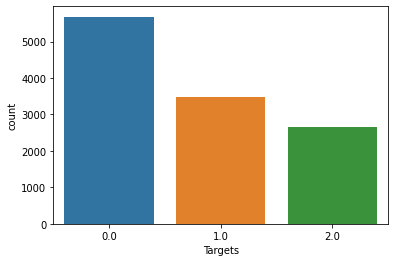

In [4]:
chart_df = preprocess_seq_data(chart_df) 

sns.countplot(chart_df, x="Targets")

In [5]:
train_columns = []
for col in chart_df.columns:
    if col not in ["Targets", "datetime", "years"]:
        train_columns.append(col)  

X = chart_df[train_columns] 
Y = chart_df["Targets"] 

train_size = int(chart_df.shape[0] * 0.8) 
val_size = int(chart_df.shape[0] * 0.1) 

X_train = X.iloc[:train_size] 
Y_train = Y.iloc[:train_size] 

X_val = X.iloc[train_size:train_size+val_size] 
Y_val = Y.iloc[train_size:train_size+val_size] 

X_test = X.iloc[train_size+val_size:] 
Y_test = Y.iloc[train_size+val_size:] 

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape 

((9449, 68), (9449,), (1181, 68), (1181,), (1182, 68), (1182,))

In [6]:
val = pd.concat([X_val, Y_val], axis=1) 
test = pd.concat([X_test, Y_test], axis=1) 

full_df = pd.concat([val, test], axis=0) 
full_df.shape

(2363, 69)

In [7]:
train_size = int(0.8 * full_df.shape[0]) 
val_size = int(0.1 * full_df.shape[0]) 

train_df = full_df.iloc[:train_size] 
val_df = full_df.iloc[train_size:train_size+val_size] 
test_df = full_df.iloc[train_size+val_size:] 

train_df.shape, val_df.shape, test_df.shape

((1890, 69), (236, 69), (237, 69))

In [8]:
X_train = train_df[train_columns] 
Y_train = train_df["Targets"] 

X_val = val_df[train_columns] 
Y_val = val_df["Targets"] 

X_test = test_df[train_columns] 
Y_test = test_df["Targets"] 

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((1890, 68), (1890,), (236, 68), (236,), (237, 68), (237,))

# Long Only

In [9]:
Y_pred = [0 for _ in range(len(Y_test))] 

cnt = 0 

for i in range(len(Y_pred)): 
    if Y_pred[i] == Y_test[i]: 
        cnt += 1 
        
accuracy = cnt / len(Y_pred) * 100 
f1 = f1_score(Y_test, Y_pred, average="weighted") 

print(f"accuracy : {accuracy}% | Weighted F1 : {f1}") 

accuracy : 13.080168776371309% | Weighted F1 : 0.030260091945336614


# Short Only 

In [10]:
Y_pred = [1 for _ in range(len(Y_test))] 

cnt = 0 

for i in range(len(Y_pred)): 
    if Y_pred[i] == Y_test[i]: 
        cnt += 1 
        
accuracy = cnt / len(Y_pred) * 100 
f1 = f1_score(Y_test, Y_pred, average="weighted") 

print(f"accuracy : {accuracy}% | Weighted F1 : {f1}") 

accuracy : 11.814345991561181% | Weighted F1 : 0.0249661651142425


# Random Agent

In [13]:
iters = 1000 

accuracies, f1s = [], [] 


for j in range(iters): 
    Y_pred = [random.randint(0, 2) for _ in range(len(Y_test))] 
    cnt = 0 
    for i in range(len(Y_pred)): 
        if Y_pred[i] == Y_test[i]: 
            cnt += 1 
    accuracy = cnt / len(Y_pred) * 100 
    f1 = f1_score(Y_test, Y_pred, average="weighted") 
    accuracies.append(accuracy) 
    f1s.append(f1) 

mu_acc = np.mean(accuracies) 
mu_f1 = np.mean(f1s) 

print(f"accuracy : {mu_acc}% | Weighted F1 : {mu_f1}") 


accuracy : 33.43417721518988% | Weighted F1 : 0.3925778747114979
